In [7]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import os

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"CUDA version: {torch.version.cuda}") if device.type == 'cuda' else None

Using device: cpu


In [9]:
import sys
sys.path.append("..")  # Add parent directory to path
from python_helpers import get_project_root_dir
from datasets import SoundTracksDataset
import models


/Users/jigneshmotwani/Moodify-CDS-2025/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
full_dataset = SoundTracksDataset()
print(f"Dataset size: {len(full_dataset)} samples")
print(f"Sample features shape: {full_dataset.melspecs[0].shape}")

Dataset size: 220 samples
Sample features shape: torch.Size([128, 323])


In [11]:
train_val, test = full_dataset.train_test_split(split_size=0.2)
train, val = train_val.train_test_split(split_size=0.25)
print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

Train: 132, Val: 44, Test: 44


In [12]:
MODEL_TYPE = 'vgg'  # Change to 'vgg' or 'nilscnn'
FEATURE_TYPE = 'melspecs'

model = {
    'nilscnn': models.NilsHMeierCNN(FEATURE_TYPE),
    'vgg': models.VGGStyleCNN(FEATURE_TYPE),
    'resnet': models.ResNetStyleCNN(FEATURE_TYPE)
}[MODEL_TYPE].to(device)

print(f"Selected model: {MODEL_TYPE.upper()}")
print(model)


Selected model: VGG
VGGStyleCNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), str

In [13]:
from train import ModelTrainer

trainer = ModelTrainer(
    task='multiclass',
    num_classes=4,
    device=device
)

In [14]:
trainer.train(
    model=model,
    train_dset=train.to(device),
    val_dset=val.to(device),
    batch_size=16,
    max_epochs=10,
    lr=0.0001,
    lambda_val=0.01,
    l1_ratio=0.0,
    take_best=True
)

Training start
Successfully saved to /Users/jigneshmotwani/Moodify-CDS-2025/runs/20250416-111209-072737/best.pt
Epoch 0    Train Loss=2.0242    Train Acc=0.2727    Val Loss=2.0304    Val Acc=0.2273
Successfully saved to /Users/jigneshmotwani/Moodify-CDS-2025/runs/20250416-111209-072737/best.pt
Epoch 1    Train Loss=2.1096    Train Acc=0.2652    Val Loss=2.1560    Val Acc=0.2500
Successfully saved to /Users/jigneshmotwani/Moodify-CDS-2025/runs/20250416-111209-072737/best.pt
Epoch 2    Train Loss=5.5361    Train Acc=0.3106    Val Loss=4.9898    Val Acc=0.3182
Successfully saved to /Users/jigneshmotwani/Moodify-CDS-2025/runs/20250416-111209-072737/best.pt
Epoch 3    Train Loss=2.1512    Train Acc=0.5909    Val Loss=2.9030    Val Acc=0.4545
Epoch 4    Train Loss=1.2890    Train Acc=0.8106    Val Loss=1.8741    Val Acc=0.4318
Successfully saved to /Users/jigneshmotwani/Moodify-CDS-2025/runs/20250416-111209-072737/best.pt
Epoch 5    Train Loss=1.1034    Train Acc=0.8561    Val Loss=2.0451   

In [18]:
test = test.to(device)
test_loss, test_acc, test_cm = trainer.evaluate_performance(model, test)
print(f"\nFinal Test Performance:")
print(f"Loss: {test_loss:.4f} | Accuracy: {test_acc:.2%}")


Final Test Performance:
Loss: 0.9617 | Accuracy: 63.64%


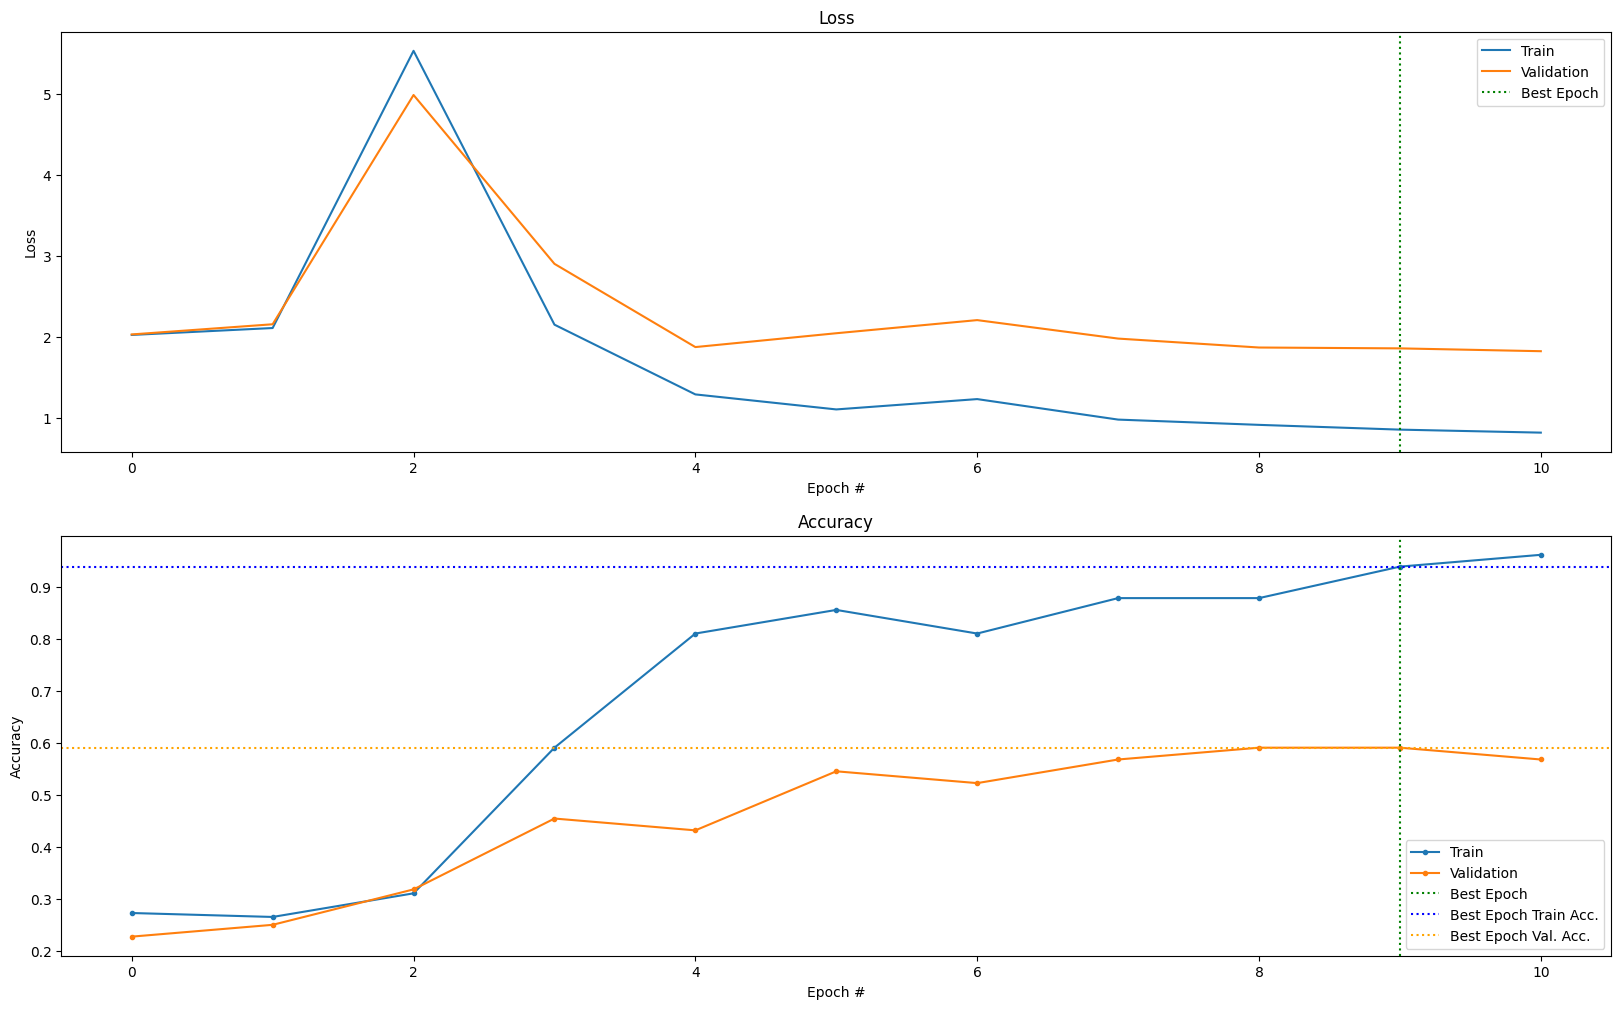

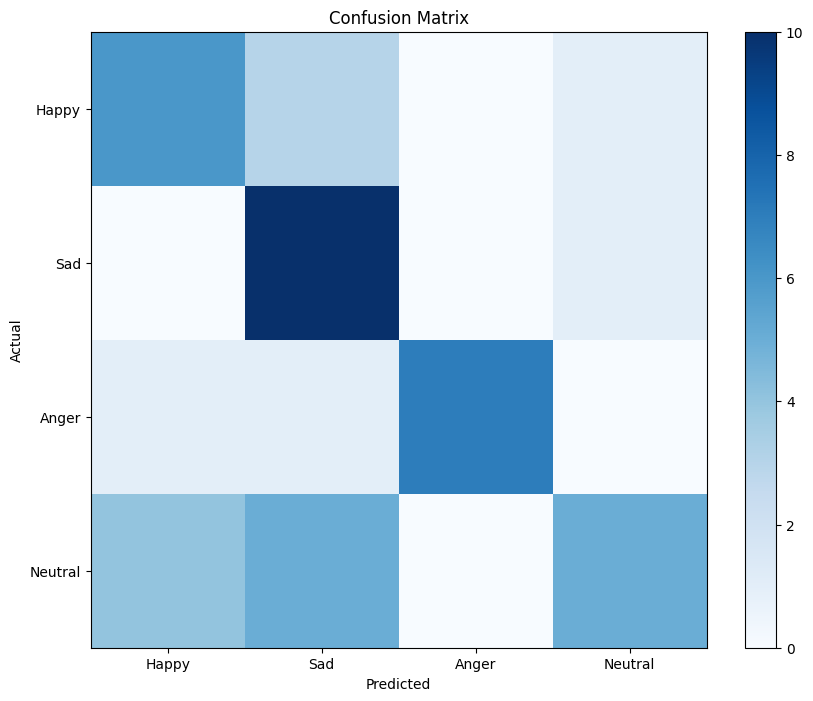

In [16]:
plt.figure(figsize=(10,8))
plt.imshow(test_cm.cpu().numpy(), cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(range(4), ['Happy', 'Sad', 'Anger', 'Neutral'])
plt.yticks(range(4), ['Happy', 'Sad', 'Anger', 'Neutral'])
plt.colorbar()
plt.show()

In [17]:
sample_idx = np.random.choice(len(test), 3)
for idx in sample_idx:
    features, true_label = test[idx]
    with torch.no_grad():
        pred = model({k:v.unsqueeze(0).to(device) for k,v in features.items()})
    
    print(f"\nSample {idx}:")
    print(f"True: {true_label.item()} | Predicted: {pred.argmax().item()}")
    display(Audio(features['waveforms'].cpu().numpy(), rate=44100))


Sample 31:
True: 3 | Predicted: 1



Sample 43:
True: 0 | Predicted: 0



Sample 0:
True: 0 | Predicted: 0
